# DATASET PREPARATION 

In [1]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image

In [2]:
p = Path("../svm multiclass classification/images/")
dirs = p.glob("*")

labels_dict = {"cat":0,"dog":1,"horse":2,"human":3}
labels = []
image_data = []

for folder in dirs:
    #print(folder)
    label = str(folder).split("\\")[-1][:-1]
    
    
    for img_path in folder.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [3]:
len(image_data),len(labels)

(808, 808)

In [4]:
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

image_data.shape,labels.shape

((808, 32, 32, 3), (808,))

# Shuffle Data 

In [5]:
import random

combined = list(zip(image_data,labels))
random.shuffle(combined)

image_data[:],labels[:] = zip(*combined)

# Visualise Data 

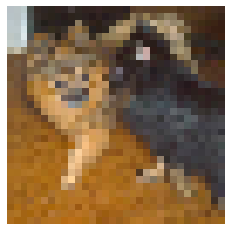

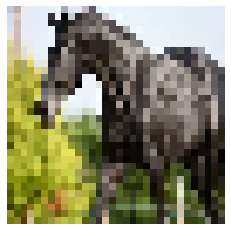

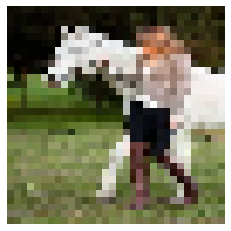

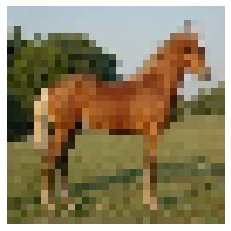

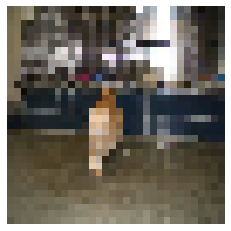

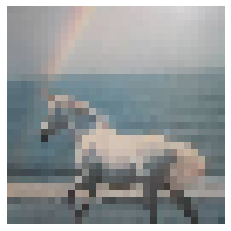

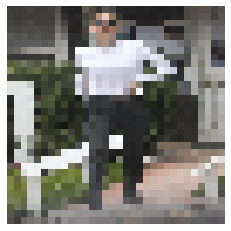

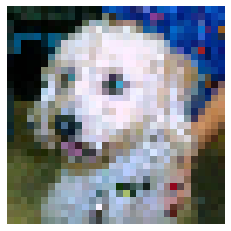

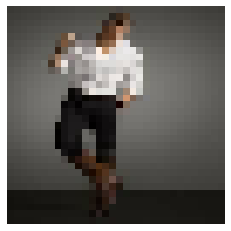

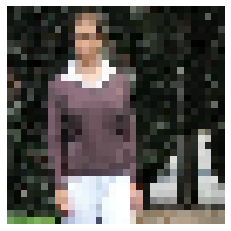

In [6]:
import matplotlib.pyplot as plt
def draw_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

for i in range(10):
    draw_img(image_data[i])

# SVM Classifier 

In [7]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule that we discussed!
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

### convert data for one vs one case

In [8]:
m = image_data.shape[0]
image_data = image_data.reshape((m,-1))

image_data.shape,labels.shape

((808, 3072), (808,))

In [9]:
classes = len(np.unique(labels))
classes

4

In [10]:
def class_wise_data(x,y):
    data = {}
    
    for i in range(classes):
        data[i] = []
        
    for i in range(m):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data


data = class_wise_data(image_data,labels)

In [12]:
data[0].shape[0],data[1].shape[0],data[2].shape[0],data[3].shape[0]

(202, 202, 202, 202)

In [13]:
data

{0: array([[0.39215687, 0.36862746, 0.28235295, ..., 0.3137255 , 0.29803923,
         0.2509804 ],
        [0.49803922, 0.02352941, 0.05882353, ..., 0.6627451 , 0.03137255,
         0.09411765],
        [0.25490198, 0.20784314, 0.14509805, ..., 0.85490197, 0.8       ,
         0.6862745 ],
        ...,
        [0.45882353, 0.42352942, 0.42745098, ..., 0.7254902 , 0.69411767,
         0.6862745 ],
        [0.72156864, 0.75686276, 0.7764706 , ..., 0.6039216 , 0.39607844,
         0.09803922],
        [0.6509804 , 0.61960787, 0.5686275 , ..., 0.12156863, 0.10588235,
         0.10980392]], dtype=float32),
 1: array([[0.72156864, 0.75686276, 0.7764706 , ..., 0.6039216 , 0.39607844,
         0.09803922],
        [0.05882353, 0.14509805, 0.09411765, ..., 0.14117648, 0.1764706 ,
         0.09411765],
        [0.60784316, 0.654902  , 0.49803922, ..., 0.5254902 , 0.5176471 ,
         0.36862746],
        ...,
        [0.52156866, 0.5019608 , 0.3764706 , ..., 0.7137255 , 0.75686276,
         0.29

In [14]:
def get_datapairs(d1,d2):
    #combines data of two classes into one matrix
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,1))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair,data_labels

In [15]:
my_svm = SVM()

In [16]:
def train_svm(x,y):
    
    svm_classifier = {}
    for i in range(classes):
        svm_classifier[i] = {}
        for j in range(i+1,classes):
            x_pair,y_pair = get_datapairs(data[i],data[j])
            wts,b,loss = my_svm.fit(x_pair,y_pair,learning_rate=0.00001,maxItr=1000)
            svm_classifier[i][j] = (wts,b)
            
    return svm_classifier

In [17]:
svm_classifier = train_svm(image_data,labels)

In [18]:
#parameters for cats and dogs
cats_dogs = svm_classifier[0][1]
print(cats_dogs[0].shape)
print(cats_dogs[1])

(1, 3072)
[-0.0185]


In [19]:
def binary_predict(x,w,b):
    z = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else: return -1

In [20]:
def predict(x):
    count = np.zeros((classes,1))
    for i in range(classes):
        for j in range(i+1,classes):
            w,b = svm_classifier[i][j]
            z = binary_predict(x,w,b)
            
            if z==1:
                count[j]+=1
            else: count[i]+=1
            
    final_pred = np.argmax(count)
    return final_pred

In [21]:
predict(image_data[0]),labels[0]

(0, 1)

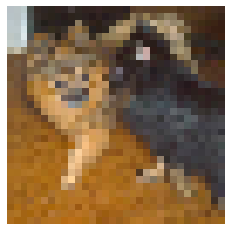

In [22]:
draw_img(image_data[0].reshape(32,32,3))

In [24]:
def accuracy(x,y):
    count = 0
    
    for i in range(x.shape[0]):
        pred = predict(x[i])
        if(pred==y[i]): count+=1
        
    return count/x.shape[0]*100

In [25]:
accuracy(image_data,labels)

58.168316831683164

# Using sklearn 

In [35]:
from sklearn import svm
from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(image_data,labels,test_size=0.2)

svm = svm.SVC(kernel='linear',C=0.1)
svm.fit(image_data,labels)
svm.score(image_data,labels)*100

63.49009900990099